In [28]:
import os
import numpy as np
from tqdm import tqdm

# Define the paths to your dataset directories
DATA_DIR_FAKE = "C:/Users/M2-Winterfell/Downloads/pulse2pulse_150k/from_006_chkp_2500_150k"
DATA_DIR_REAL = "C:/Users/M2-Winterfell/Downloads/real_ecgs"

# Function to load and extract Lead I from a single .asc file
def load_lead_I_from_asc(file_path):
    try:
        # Load the .asc file (assuming it's space or tab-delimited)
        ecg_data = np.loadtxt(file_path)

        # Extract Lead I (assuming first column is Lead I)
        lead_I = ecg_data[:, 0]  # Lead I

        return lead_I
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Function to load exactly 2000 Lead I ECG data from a specified directory with a progress bar
def load_exactly_2000_lead_I_from_directory(data_dir, n=2000):
    all_lead_I = []
    i = 0

    # Initialize the progress bar
    with tqdm(total=n, desc=f"Loading Lead I from {data_dir.split('/')[-1]}", unit='file') as pbar:
        # Load ECG files until we have 2000 valid files
        while len(all_lead_I) < n:
            file_name = f"{i}.asc"
            file_path = os.path.join(data_dir, file_name)

            if os.path.exists(file_path):
                lead_I = load_lead_I_from_asc(file_path)
                if lead_I is not None:
                    all_lead_I.append(lead_I)
                    pbar.update(1)  # Update progress bar when a valid file is loaded

            i += 1

    # Convert list to NumPy array
    all_lead_I = np.array(all_lead_I)

    return all_lead_I

# Load exactly 2000 Lead I ECG records from both directories
lead_I_real = load_exactly_2000_lead_I_from_directory(DATA_DIR_REAL, n=2000)
lead_I_fake = load_exactly_2000_lead_I_from_directory(DATA_DIR_FAKE, n=2000)


# Check if data was loaded successfully
if lead_I_fake.size > 0 and lead_I_real.size > 0:
    print(f"Total Lead I records loaded from real data: {lead_I_real.shape[0]}")
    print(f"Total Lead I records loaded from fake data: {lead_I_fake.shape[0]}")
else:
    print("No data was loaded.")


Loading Lead I from from_006_chkp_2500_150k: 100%|██████████| 2000/2000 [00:09<00:00, 213.82file/s]


Total Lead I records loaded from real data: 2000
Total Lead I records loaded from fake data: 2000


In [40]:
print('Real ECG Shape:      ', lead_I_real.shape)
print('Fake ECG Shape:      ', lead_I_fake.shape)

Real ECG Shape:       (2000, 5000)
Fake ECG Shape:       (2000, 5000)


In [41]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return 2 * (data - min_val) / (max_val - min_val) - 1
lead_I_real = np.array([min_max_normalize(ecg) for ecg in lead_I_real])
lead_I_fake = np.array([min_max_normalize(ecg) for ecg in lead_I_fake])

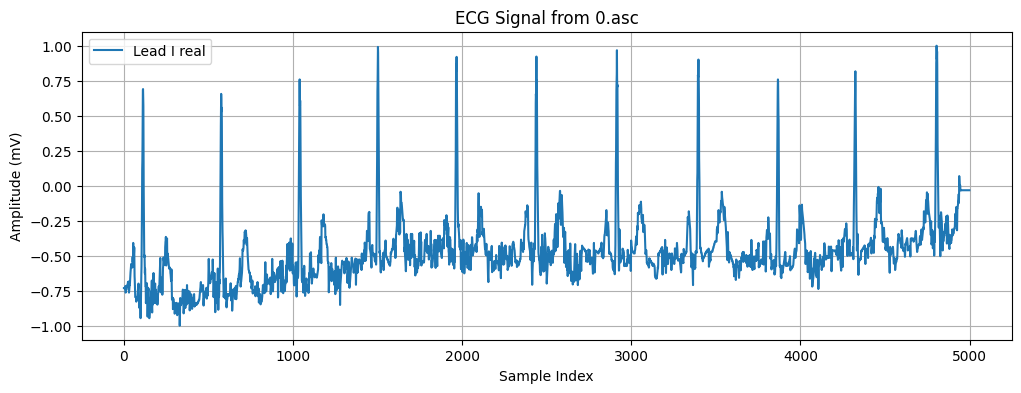

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(lead_I_real[0], label="Lead I real")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (mV)")
plt.title("ECG Signal from 0.asc")
plt.legend()
plt.grid()
plt.show()

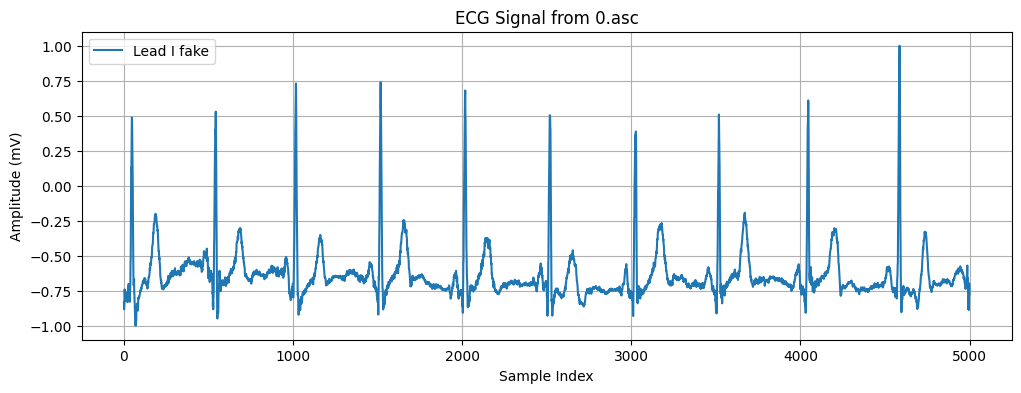

In [45]:
plt.figure(figsize=(12, 4))
plt.plot(lead_I_fake[0], label="Lead I fake")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (mV)")
plt.title("ECG Signal from 0.asc")
plt.legend()
plt.grid()
plt.show()

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Combine data and labels
X = np.concatenate((lead_I_fake, lead_I_real), axis=0)  # Shape: (4000, samples_per_record)
y = np.concatenate((np.zeros(lead_I_fake.shape[0]), np.ones(lead_I_real.shape[0])), axis=0)  # Labels: 0 for fake, 1 for real

In [48]:
# Normalize the data (optional, depending on ECG value ranges)
# X = X.astype('float32') / np.max(np.abs(X))  # Normalize between -1 and 1

# Split the data into training and test sets (shuffle=True to mix real and fake ECGs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Since ECG data is 1D, the input shape will be (samples_per_record, 1)
INPUT_SHAPE = (X_train.shape[1], 1)

# Reshape data to be in the format (samples, time_steps, 1)
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

# Print the shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (3200, 5000, 1)
X_test shape: (800, 5000, 1)


In [49]:
# CNN Model Architecture for 1D Data (ECG signals)
model = Sequential()

# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
# MaxPooling layer
model.add(MaxPooling1D(pool_size=2))
# Dropout layer
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

# Flatten layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
# Output layer (sigmoid activation for binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.005)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# EarlyStopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
batch_size = 32
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=batch_size,
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/50
100/100 [==============================] - 109s 1s/step - loss: 4.3526 - accuracy: 0.5906 - val_loss: 9.6244 - val_accuracy: 0.5275
Epoch 2/50
100/100 [==============================] - 88s 881ms/step - loss: 0.6600 - accuracy: 0.6419 - val_loss: 13.8862 - val_accuracy: 0.5238
Epoch 3/50
100/100 [==============================] - 79s 790ms/step - loss: 0.5741 - accuracy: 0.7016 - val_loss: 1.1144 - val_accuracy: 0.4613
Epoch 4/50
100/100 [==============================] - 77s 774ms/step - loss: 0.3475 - accuracy: 0.8456 - val_loss: 5.3609 - val_accuracy: 0.4725
Epoch 5/50
100/100 [==============================] - 77s 772ms/step - loss: 0.1726 - accuracy: 0.9456 - val_loss: 0.6321 - val_accuracy: 0.7462
Epoch 6/50
100/100 [==============================] - 78s 784ms/step - loss: 0.3382 - accuracy: 0.8813 - val_loss: 3.8897 - val_accuracy: 0.7013
Epoch 7/50
100/100 [==============================] - 77s 771ms/step - loss: 0.1470 - accuracy: 0.9603 - val_loss: 0.0747 - val_acc

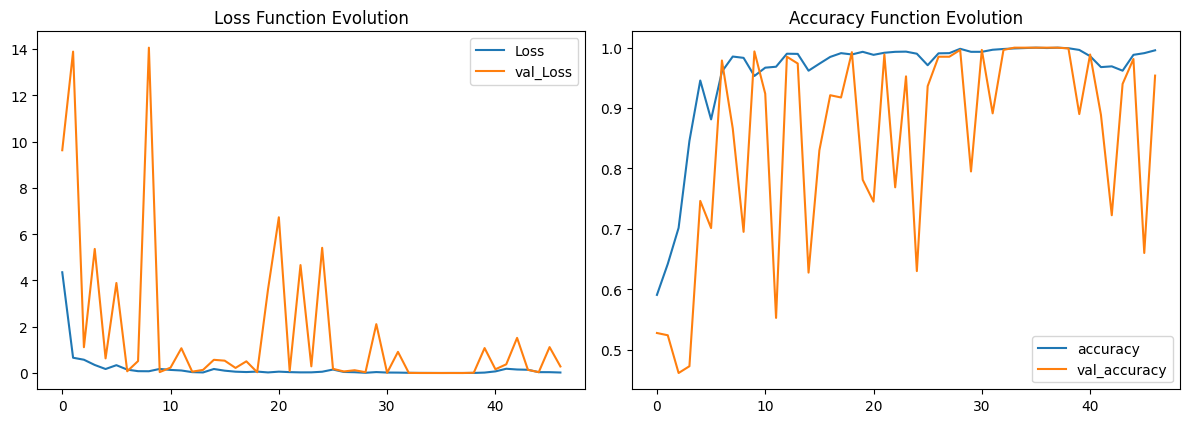

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Plotting
plt.figure(figsize=(12, 16))

# Loss plot
plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

# Accuracy plot
plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()


plt.tight_layout()
plt.show()

25/25 [==============================] - 3s 126ms/step - loss: 1.0069e-07 - accuracy: 1.0000
Test Accuracy: 100.00%
25/25 [==============================] - 4s 129ms/step


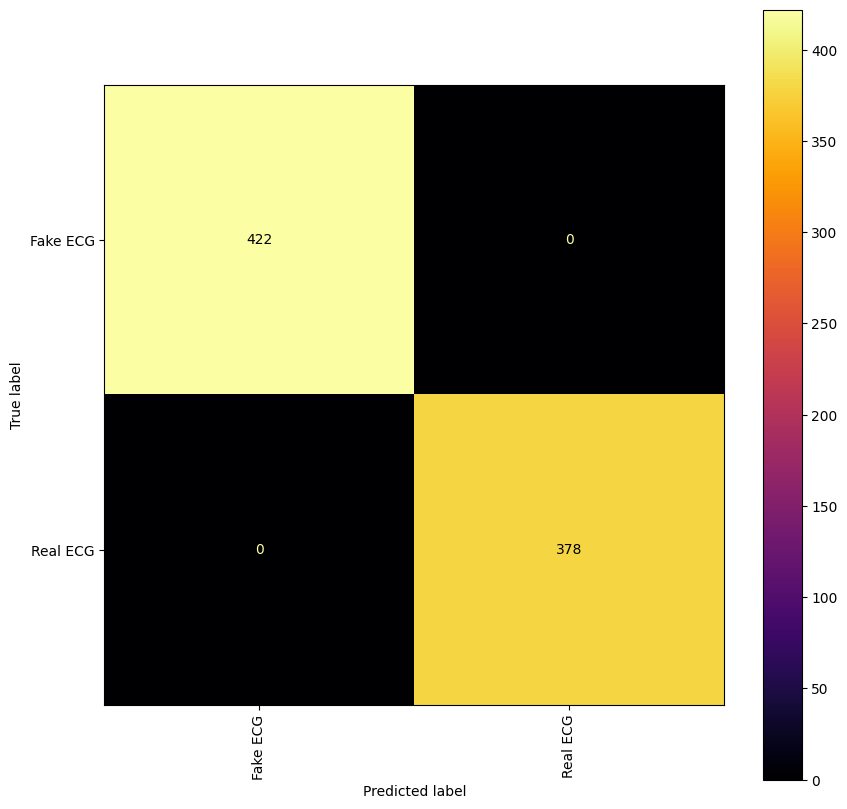

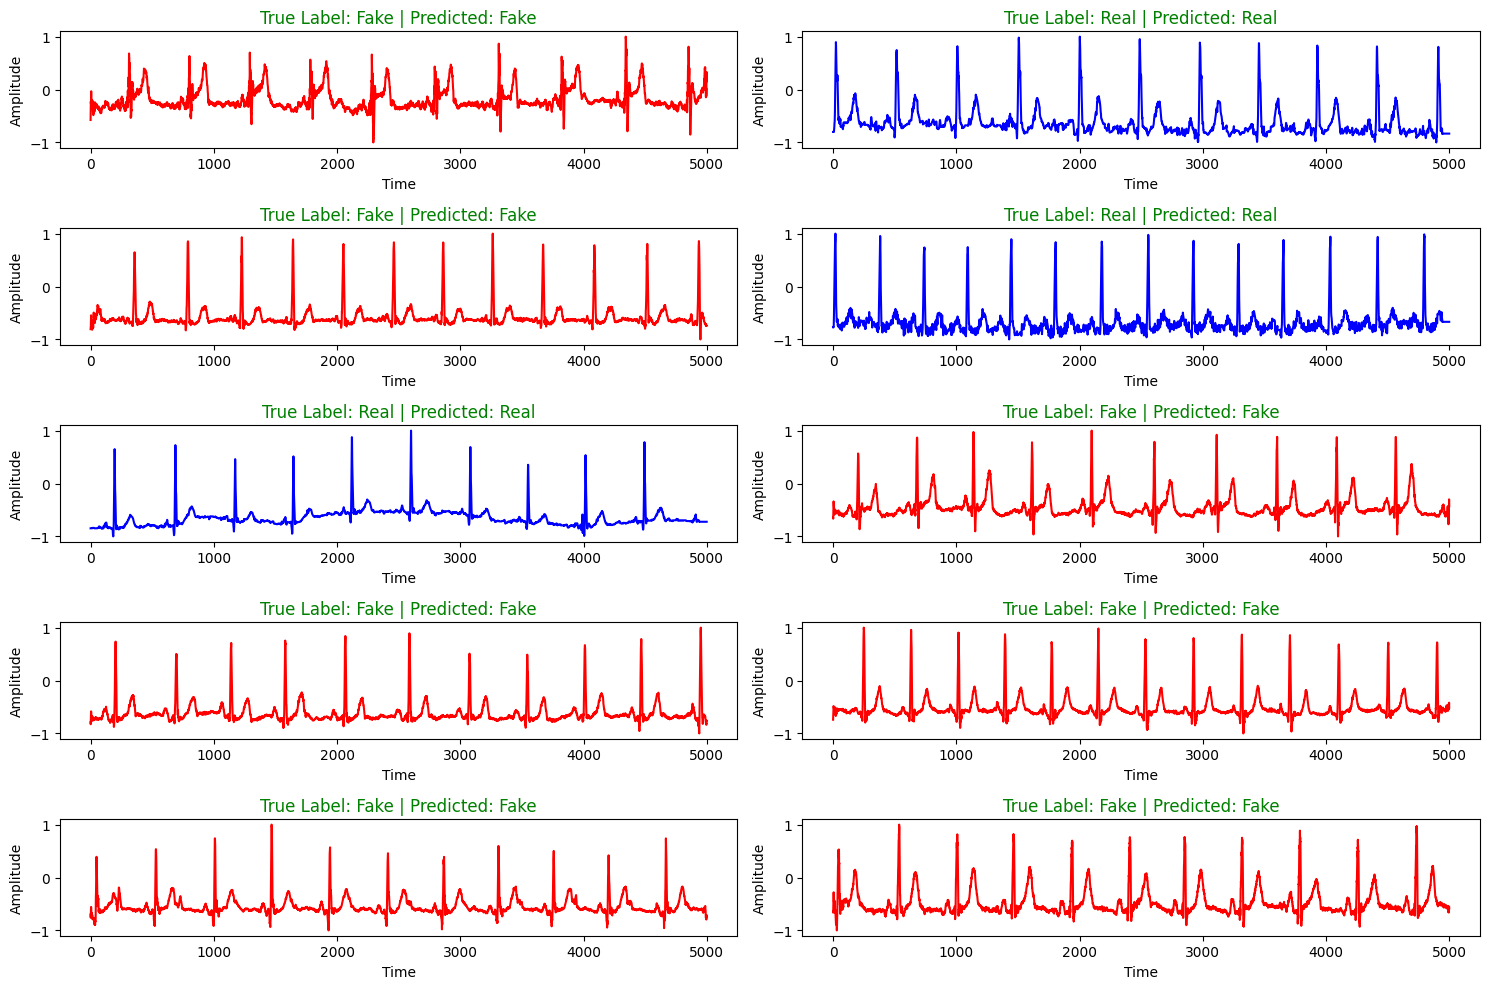

In [54]:
# Model Evaluation
evaluation = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')

# Predict on test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32").flatten()  # Convert probabilities to binary labels (0 or 1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake ECG", "Real ECG"])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(xticks_rotation='vertical', ax=ax, cmap='inferno')

plt.show()

# Visualizing some ECG signals
num_samples = 10  # Number of samples to visualize
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    plt.subplot(5, 2, i + 1)
    plt.plot(X_test[i].squeeze(), color='blue' if y_test[i] == 1 else 'red')  # Blue for real, Red for fake
    plt.title(f"True Label: {'Real' if y_test[i] == 1 else 'Fake'} | Predicted: {'Real' if y_pred[i] == 1 else 'Fake'}",
              color='green' if y_test[i] == y_pred[i] else 'red')
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()
